In [15]:
import numpy as np
import quimb as qu
from itertools import product
import torch
import math
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ExponentialLR, MultiplicativeLR, MultiStepLR, CyclicLR, ConstantLR, SequentialLR

import h5py

from models import Lindbladian
from ml.classes import MLLP
from sfw.optimizers import Adam
from ml.core import train, eval

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [4]:
# base elements
F = []
pauli = {'I' : qu.pauli('I'),
        'X' : qu.pauli('X'),
        'Y' : qu.pauli('Y'),
        'Z' : qu.pauli('Z')}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    F.append(0.5*pauli[ob1]&pauli[ob2])

def initial_conditions():
    rho = qu.gen.rand.rand_rho(4)

    v_0 = np.array([np.trace(np.dot(f,rho)) for f in F]).real
    return v_0[1:]

In [5]:
def print_comparison(data_tebd, data_ml, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_tebd[k][columns*i+j] for k in range(len(t))], label='Simulation', color='k')
            axs[i, j].plot(t, [data_ml[k][columns*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [6]:
def print_comparison_omega(LL, model, T, dt=0.01):
    time = np.arange(0, T, dt)
    
    rows= 5
    columns = 3
    ylim = 1
    
    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))
    
    model.eval()
    for i in range(rows):
        for j in range(columns):
            omega_true = np.array([LL.omega(t).numpy()[columns*i+j] for t in time])
            omega_learned = np.array([model.MLP.get_omega(t)[columns*i+j] for t in time])
            axs[i, j].plot(time, omega_true, label='True', color='k')
            axs[i, j].plot(time, omega_learned, label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            #axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [7]:
def print_comparison_rates(LL, model, T, dt=0.01):
    time = np.arange(0, T, dt)
    
    rows= 5
    columns = 3
    ylim = 1
    
    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    model.eval()
    for i in range(rows):
        for j in range(columns):
            omega_true = np.array([LL.get_rates(t)[columns*i+j] for t in time])
            omega_learned = np.array([model.MLP.get_rates(t)[columns*i+j] for t in time])
            axs[i, j].plot(time, omega_true, label='True', color='k')
            axs[i, j].plot(time, omega_learned, label='ml', color='r', linestyle='--')
            axs[i, j].grid()
            #axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [8]:
def load_data(path, model, T_train, num_traj, validation_split, batch_size, resize=False):
    '''Function to load the NORMALIZED data from hdf5 file.
    Reshuffling of data is performed. Then separates train
    from validation and return the iterables.
    NOTE: this functions takes both beta and potential as arrays
    in case one wants to have wider training sets.

    Parameters
    ----------
    path : str
        Path to the hdf5 file
    T_train : int
        Time used in the training procedure
    num_traj : int
    validation_split : float
        Number 0 < .. < 1 which indicates the relative
        sizes of validation and train

    Return
    ------
    train and validation loaders
    '''

    # list of group names
    gname = 'cohVec_model' + str(model) + \
    '_T_' + str(T_train).zfill(2)

    dataset = CustomDatasetFromHDF5(path, gname, T_train, 0.01, num_traj, resize)

    # creating the indeces for training and validation split
    dataset_size = len(dataset)
    indeces = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    # shuffling the datesets
    np.random.seed(42)
    np.random.shuffle(indeces)
    train_indices, val_indices = indeces[split:], indeces[:split]

    # Creating PT data samplers and loaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             sampler=valid_sampler)
    return train_loader, val_loader

In [9]:
class CustomDatasetFromHDF5(Dataset):
    '''Class implementing the Dataset object, for
    the data, to the pass to DataLoader. It directly takes
    the data from the hdf5 file
    NOTE: here I also normalize the data respect to beta!

    Parameters
    ----------
    path : str
        Path to where hdf5 file is
    group : array of str
        Group name or names of the desired data
    T_train : int
        Max time to reach
    dt : float
        Time increment used in data generation
    num_traj : int
        Number of trajectories
    resize : bool
        To resize the dataset according to T_train
    '''

    def __init__(self, path, group, T_train, dt, num_traj, resize):
        with h5py.File(path, 'r') as f:
            self.X = []
            self.y = []
            self.t = []
            self.V = [] # dummy vector

            # extract beta from the name
            beta = 1
            normalization = 1 - math.e**(-beta/2)

            if resize:
                data_short_X = []
                data_short_y = []

                # have to calculate how long each block is
                block = int(f[g+'/X'][()].shape[0]/num_traj)
                # calculate how much to include for each traj
                tt = int(T_train/dt)

                for n in range(num_traj):
                    data_short_X.extend(f[g + '/X'][n*block:n*block+tt])
                    data_short_y.extend(f[g + '/y'][n*block:n*block+tt])

                # normalizing and appending
                self.X.extend([x/normalization for x in data_short_X])
                self.y.extend([y/normalization for y in data_short_y])
                # creating the time vector based on T_train
                for _ in range(num_traj):
                    self.t.extend([i*dt for i in range(int(T_train/dt))])

            else:
                self.X.extend(f[group + '/X'][()] / normalization)
                self.y.extend(f[group + '/y'][()] / normalization)


                # creating the time vector based on T_train
                for _ in range(num_traj):
                    self.t.extend([i*dt for i in range(int(T_train/dt) - 1)])
                    
                self.V.extend([0]*len(f[group + '/X'][()]))


    def __getitem__(self, index):
        # return the potential and the vector at t and t+dt
        # as tensors
        return torch.tensor(self.V[index]), torch.tensor(self.t[index]), \
            torch.tensor(self.X[index]), torch.tensor(self.y[index])

    def __len__(self):
        return len(self.X)

# Time dependent model
Here I want to test if the model is able to actually learn a time dependent model.


# Lindblad 1

$$H = \frac{\cos(\omega_1 t)}{2} ( \sigma_1^x + \sigma_2^x  )$$
$$J = \sin(\omega_2 t) ( \sigma_1^{-} \sigma_2^{-}  )$$

In [318]:
class L_1(Lindbladian):
    def __init__(self, omega_1, omega_2):
        super(L_1, self).__init__()
        self.o1 = omega_1
        self.o2 = omega_2
    
    def kossakowski(self, t):
        s = torch.zeros((15), dtype=torch.cfloat)
        s[4] = 0.5
        s[5] = -0.5j
        s[8] = -0.5j
        s[9] = -0.5
        gamma = (np.sin(self.o2*t))**2

        return torch.einsum('i,j->ij', s, s.conj())*gamma

    def omega(self, t):
        w = torch.zeros((15))
        w[0] = np.cos(self.o1*t)
        w[3] = np.cos(self.o1*t)

        return w

In [319]:
prms = {'model': 1,
        'omega_1': 1,
        'omega_2': 1,
        'T': 10,
        'T_test':20,
        'num_traj': 30}

L = L_1(prms['omega_1'],prms['omega_2'])

## Data generation

In [321]:
### TRAINING
fname = './data/data_TDL_training.hdf5'
X = []
y = []

for i in range(prms['num_traj']):
    v_0 = initial_conditions()
    results = L.generate_trajectory(v_0=v_0, T=prms['T'])
    
    X.extend(results[:-1])
    y.extend(results[1:])

# save to file
file = h5py.File(fname, 'a')

# group name in hdf5 file
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)

# create the subgroup
subg = file.create_group(gname)

subg.create_dataset('X', data=X)
subg.create_dataset('y', data=y)

file.close()

In [322]:
### TESTING
fname = './data/data_TDL_test.hdf5'

v_0 = initial_conditions()
results = L.generate_trajectory(v_0=v_0, T=prms['T_test'])
    
X = results[:-1]
y = results[1:]

# save to file
file = h5py.File(fname, 'a')

# group name in hdf5 file
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)

# create the subgroup
subg = file.create_group(gname)

subg.create_dataset('X', data=X)
subg.create_dataset('y', data=y)

file.close()

## Model training
Here I use the frequencie initialized at the right frequencies.

omega @ 1, gamma @ 2

= Starting epoch  1 / 600
=== Mean train loss: 0.006337247279
=== lr: 0.00100
= Starting epoch  2 / 600
=== Mean train loss: 0.004278571107
=== lr: 0.00100
= Starting epoch  3 / 600
=== Mean train loss: 0.002288999516
=== lr: 0.00100
= Starting epoch  4 / 600
=== Mean train loss: 0.001235700900
=== lr: 0.00100
= Starting epoch  5 / 600
=== Mean train loss: 0.000505209969
=== lr: 0.00100
= Starting epoch  6 / 600
=== Mean train loss: 0.000304910848
=== lr: 0.00100
= Starting epoch  7 / 600
=== Mean train loss: 0.000259080224
=== lr: 0.00100
= Starting epoch  8 / 600
=== Mean train loss: 0.000231798602
=== lr: 0.00100
= Starting epoch  9 / 600
=== Mean train loss: 0.000209843089
=== lr: 0.00100
= Starting epoch  10 / 600
=== Mean train loss: 0.000191078440
=== lr: 0.00100
= Starting epoch  11 / 600
=== Mean train loss: 0.000175056920
=== lr: 0.00100
= Starting epoch  12 / 600
=== Mean train loss: 0.000160410464
=== lr: 0.00100
= Starting epoch  13 / 600
=== Mean train loss: 0.00014645818

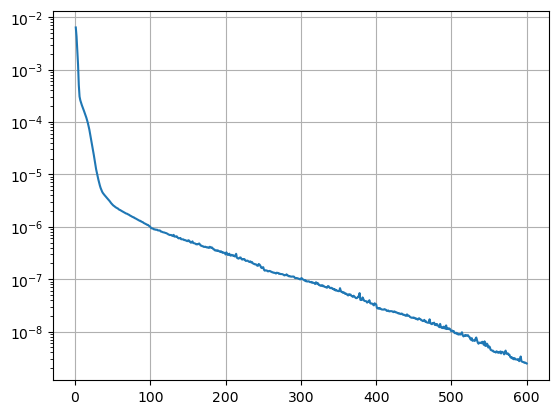

In [251]:
ml_params = {'model_dir': './data/trained_TDL/',  # folder where the metadata of the training are stored
             'validation_split': 0.9,
             'batch_size': 64,
             'time_dependent': True,
             # 'batches_per_epoch': 256,
             'n_epochs': 600,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/data_TDL_training.hdf5', 
                                      1, prms['T'], prms['num_traj'], 
                                      ml_params['validation_split'],                                               
                                      ml_params['batch_size'])
# create the model
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#scheduler = ExponentialLR(optimizer, 0.995)
scheduler = MultiStepLR(optimizer, milestones=[100, 250, 400, 550], gamma=0.5)
# lmbda = lambda epoch: 0.95
#scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            epochs_to_prune=[])

# eval the model
#eval(model, criterion, eval_loader, ml_params['device'])

# save the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1,ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

In [ ]:
u_re = model.MLP.u_re
u_im = model.MLP.u_im

theta = u_re +1j*u_im + u_re.T -1j*u_im.T
u = torch.matrix_exp(1j*theta)

u = torch.matrix_exp(1j*theta)
u_T = torch.matrix_exp(-1j*theta.H)
torch.abs(torch.sum(torch.eye(15) - (u.H@u).detach()))

In [ ]:
print(model.MLP.gamma_net.frequencies)
model.MLP.gamma_net.weights

In [ ]:
print(model.MLP.omega_net.frequencies)
model.MLP.omega_net.weights

## Comparison

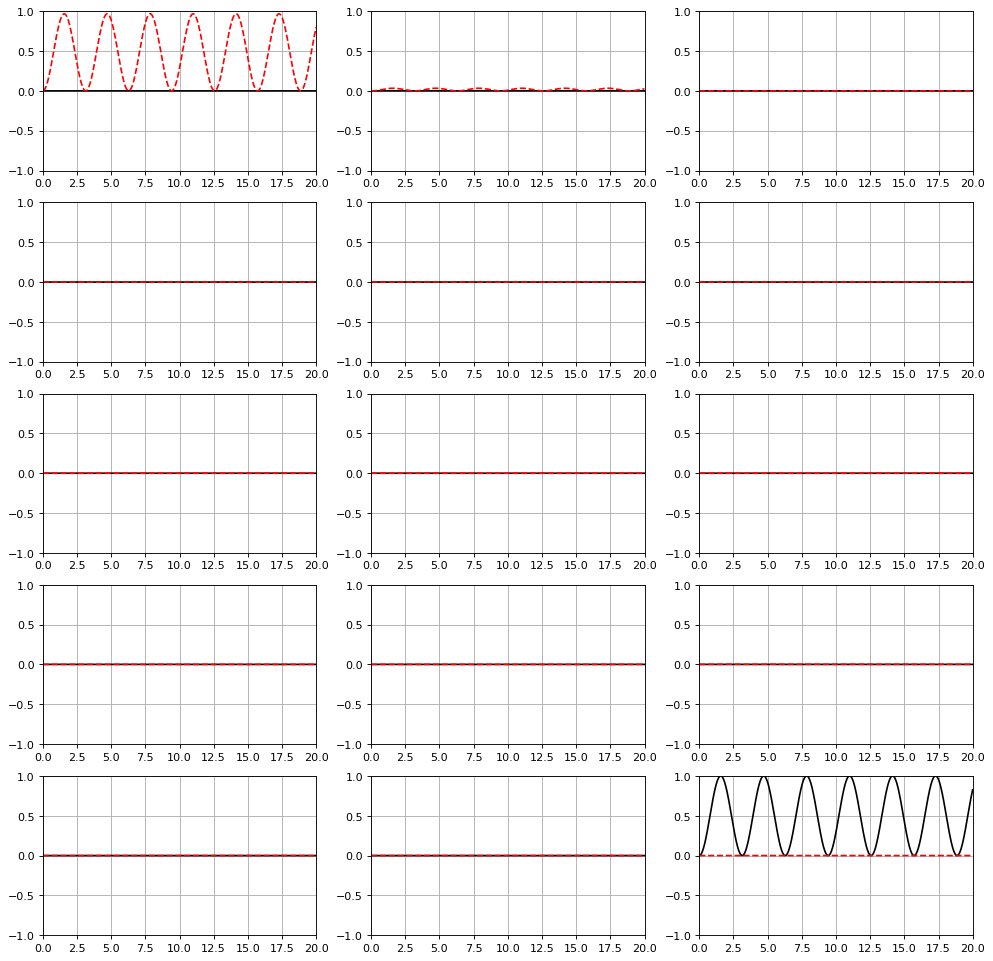

In [252]:
print_comparison_rates(L, model, 20)

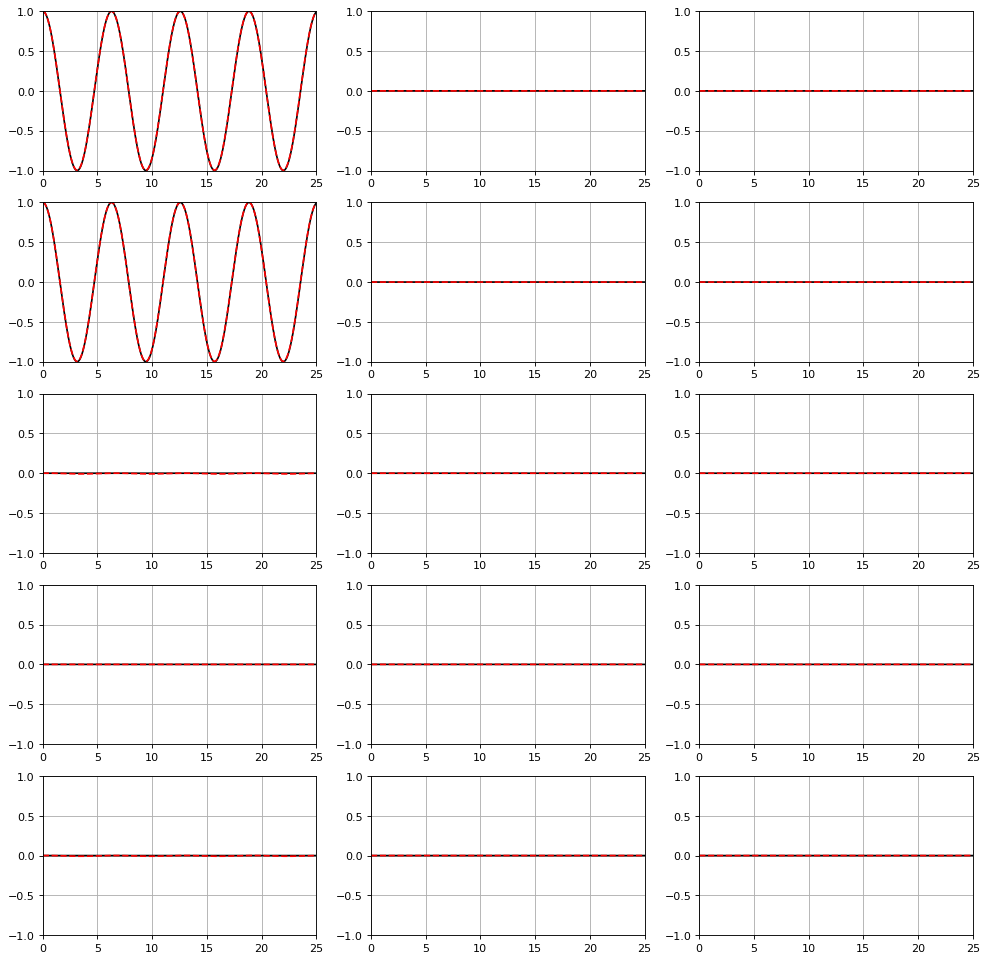

In [253]:
print_comparison_omega(L, model, 25)

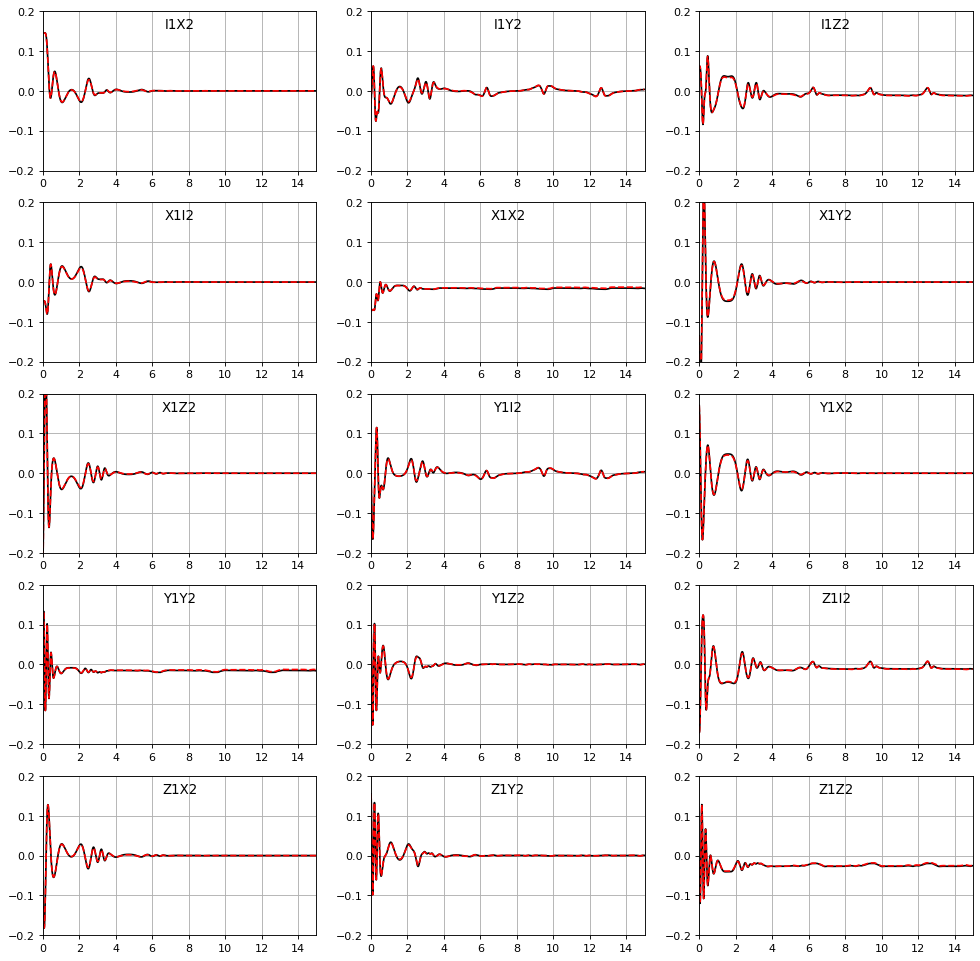

In [254]:
# import TEBD data
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)
with h5py.File('./data/data_TDL_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

model = MLLP(ml_params['mlp_params'], potential=0,
            time_dependent=ml_params['time_dependent']).to(ml_params['device'])
model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T_test'], beta=1)

print_comparison(data_tebd, ml_dyn, 15, dt=0.01, ylim=0.2)

## Different initial conditions
Here I initialize the frequencies at 1.5

= Starting epoch  1 / 600
=== Mean train loss: 0.002901416889
=== lr: 0.01000
= Starting epoch  2 / 600
=== Mean train loss: 0.000241075039
=== lr: 0.01000
= Starting epoch  3 / 600
=== Mean train loss: 0.000082923958
=== lr: 0.01000
= Starting epoch  4 / 600
=== Mean train loss: 0.000039569935
=== lr: 0.01000
= Starting epoch  5 / 600
=== Mean train loss: 0.000013761670
=== lr: 0.01000
= Starting epoch  6 / 600
=== Mean train loss: 0.000009418150
=== lr: 0.01000
= Starting epoch  7 / 600
=== Mean train loss: 0.000008346842
=== lr: 0.01000
= Starting epoch  8 / 600
=== Mean train loss: 0.000008015039
=== lr: 0.01000
= Starting epoch  9 / 600
=== Mean train loss: 0.000007256445
=== lr: 0.01000
= Starting epoch  10 / 600
=== Mean train loss: 0.000006888918
=== lr: 0.01000
= Starting epoch  11 / 600
=== Mean train loss: 0.000006790260
=== lr: 0.01000
= Starting epoch  12 / 600
=== Mean train loss: 0.000006661633
=== lr: 0.01000
= Starting epoch  13 / 600
=== Mean train loss: 0.00000667376

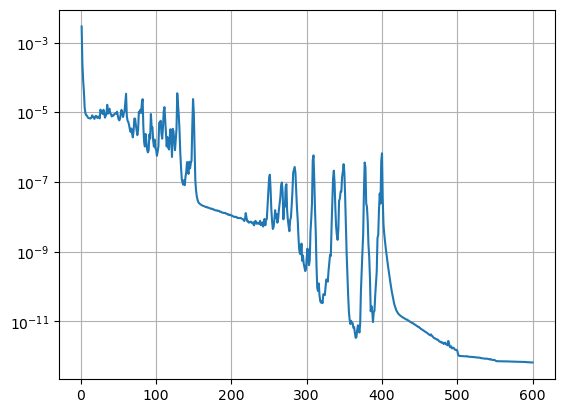

In [269]:
ml_params = {'model_dir': './data/trained_TDL/',  # folder where the metadata of the training are stored
             'validation_split': 0.9,
             'batch_size': 64,
             'time_dependent': True,
             # 'batches_per_epoch': 256,
             'n_epochs': 600,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/data_TDL_training.hdf5', 
                                      1, prms['T'], prms['num_traj'], 
                                      ml_params['validation_split'],                                               
                                      ml_params['batch_size'])
# create the model
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
#scheduler = ExponentialLR(optimizer, 0.995)
scheduler = MultiStepLR(optimizer, milestones=[150, 400, 500, 550], gamma=0.1)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            epochs_to_prune=[])

# save the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1,ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

In [270]:
print(model.MLP.gamma_net.frequencies)
print(model.MLP.omega_net.frequencies)

Parameter containing:
tensor([2.0000], requires_grad=True)
Parameter containing:
tensor([1.0000], requires_grad=True)


### Comparison

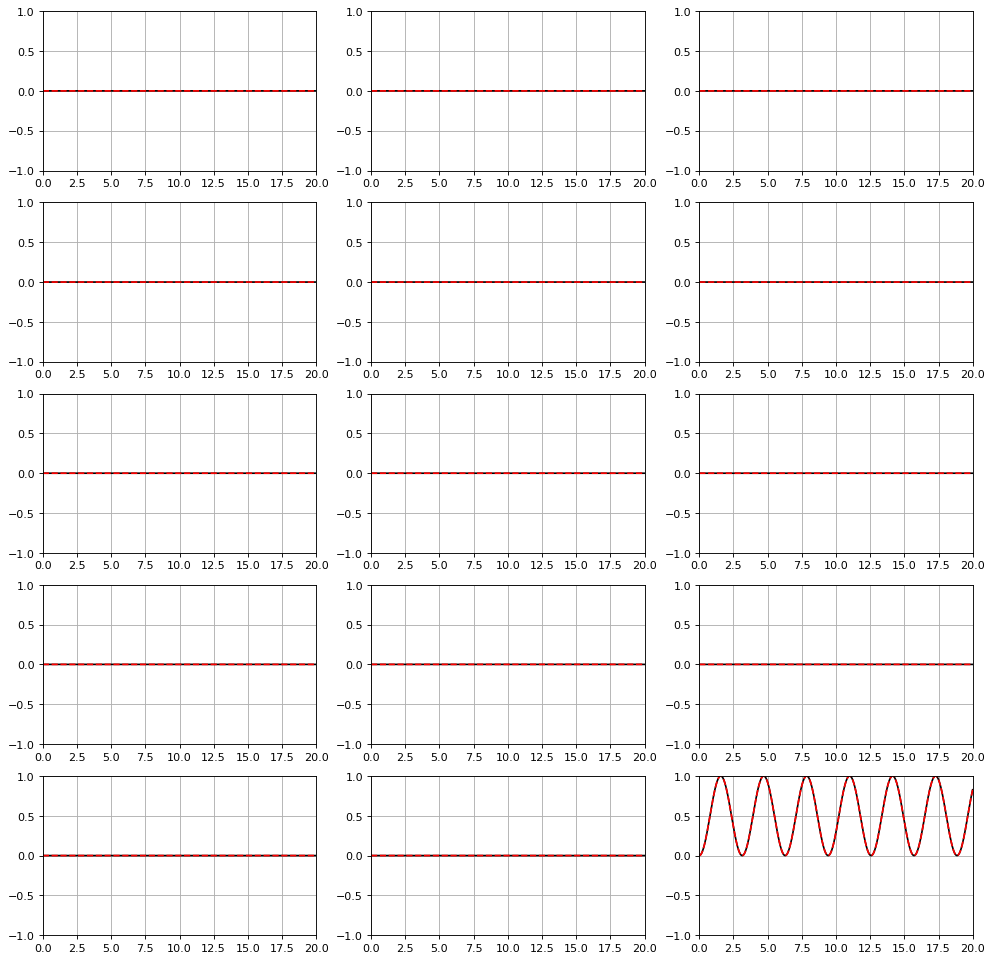

In [271]:
print_comparison_rates(L, model, 20)

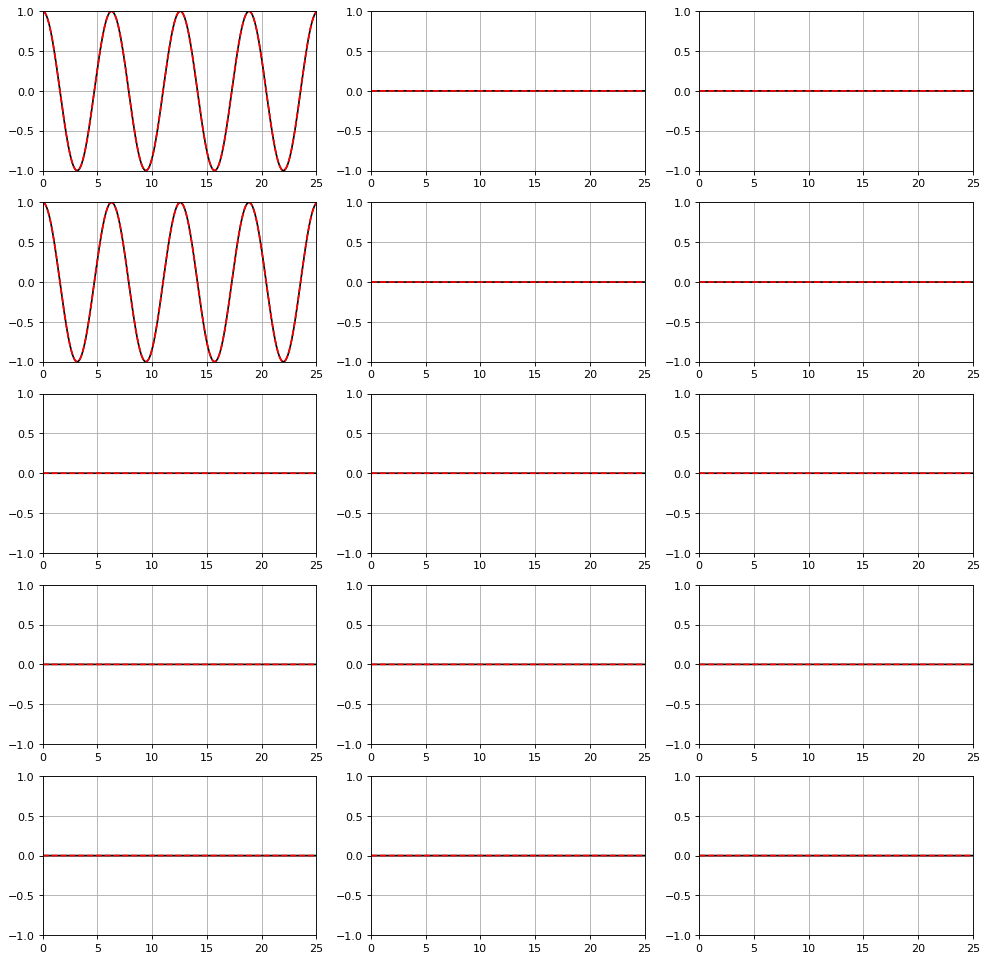

In [272]:
print_comparison_omega(L, model, 25)

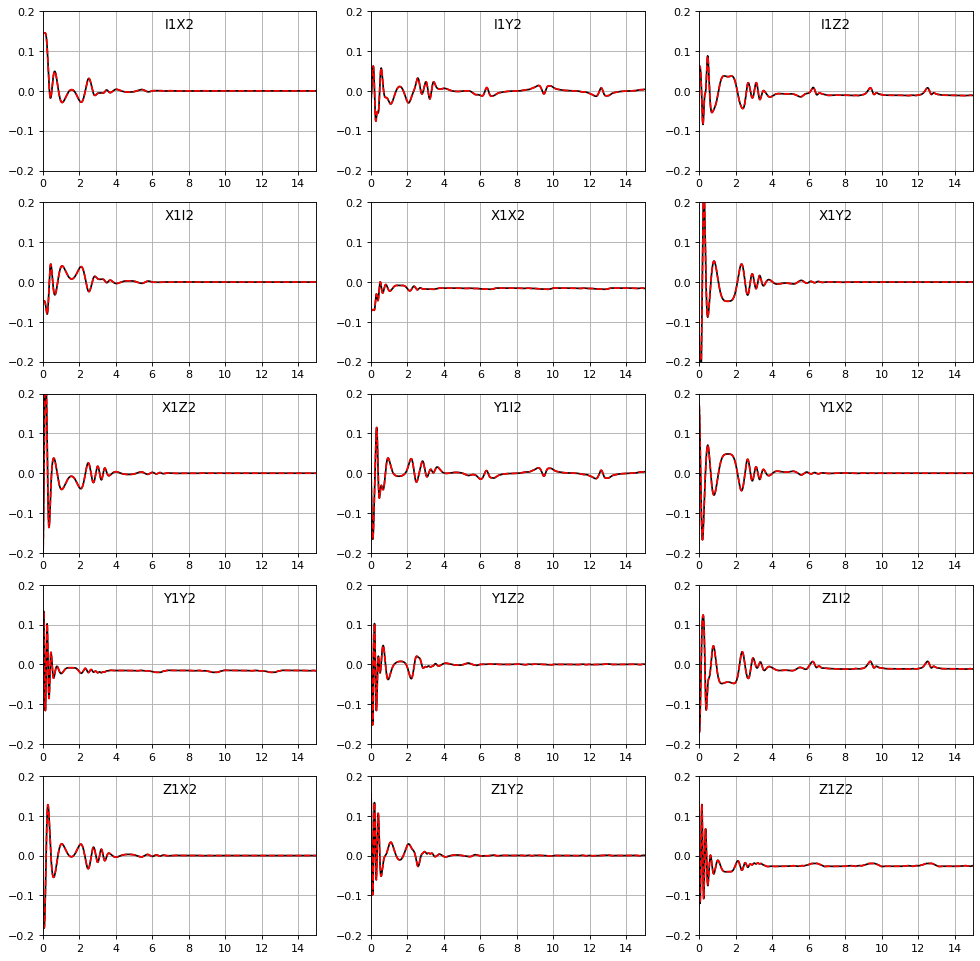

In [273]:
# import TEBD data
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)
with h5py.File('./data/data_TDL_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

model = MLLP(ml_params['mlp_params'], potential=0,
            time_dependent=ml_params['time_dependent']).to(ml_params['device'])
model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T_test'], beta=1)

print_comparison(data_tebd, ml_dyn, 15, dt=0.01, ylim=0.2)

## Lindblad 1 : More frequencies
Instead of using one frequency I give to the model 3 frequencies (both for omega and gamma).

- Initialized @ 0.5, 1.5, 5 -> the model partially succsessfull. BUt the loss keps going down, so I am guessing a longer training will yield a better model.

= Starting epoch  1 / 1000
=== Mean train loss: 45.963684984978
=== lr: 0.00995
= Starting epoch  2 / 1000
=== Mean train loss: 2.496528506279
=== lr: 0.00990
= Starting epoch  3 / 1000
=== Mean train loss: 0.621863839474
=== lr: 0.00985
= Starting epoch  4 / 1000
=== Mean train loss: 0.181546615001
=== lr: 0.00980
= Starting epoch  5 / 1000
=== Mean train loss: 0.063465495693
=== lr: 0.00975
= Starting epoch  6 / 1000
=== Mean train loss: 0.024145629752
=== lr: 0.00970
= Starting epoch  7 / 1000
=== Mean train loss: 0.013089060338
=== lr: 0.00966
= Starting epoch  8 / 1000
=== Mean train loss: 0.008786723047
=== lr: 0.00961
= Starting epoch  9 / 1000
=== Mean train loss: 0.006231352566
=== lr: 0.00956
= Starting epoch  10 / 1000
=== Mean train loss: 0.004448292326
=== lr: 0.00951
= Starting epoch  11 / 1000
=== Mean train loss: 0.003285584161
=== lr: 0.00946
= Starting epoch  12 / 1000
=== Mean train loss: 0.002647875038
=== lr: 0.00942
= Starting epoch  13 / 1000
=== Mean train loss:

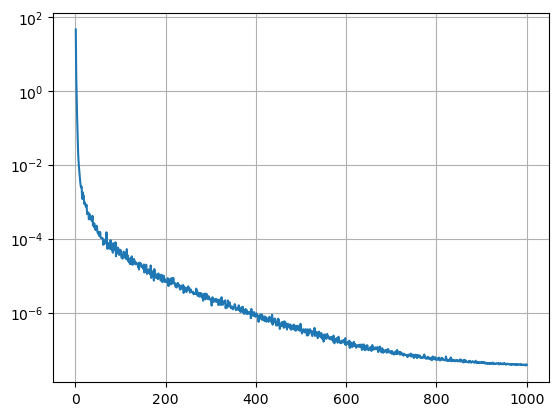

In [442]:
ml_params = {'model_dir': './data/trained_TDL/',  # folder where the metadata of the training are stored
             'validation_split': 0.9,
             'batch_size': 64,
             'time_dependent': True,
             # 'batches_per_epoch': 256,
             'n_epochs': 1000,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/data_TDL_training.hdf5', 
                                      1, prms['T'], prms['num_traj'], 
                                      ml_params['validation_split'],                                               
                                      ml_params['batch_size'])
# create the model
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01, betas=[0.8, 0.9])
scheduler = ExponentialLR(optimizer, 0.995)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            epochs_to_prune=[], lamda=1e-4)

# eval the model
#eval(model, criterion, eval_loader, ml_params['device'])

# save the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1,ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

### Comparison

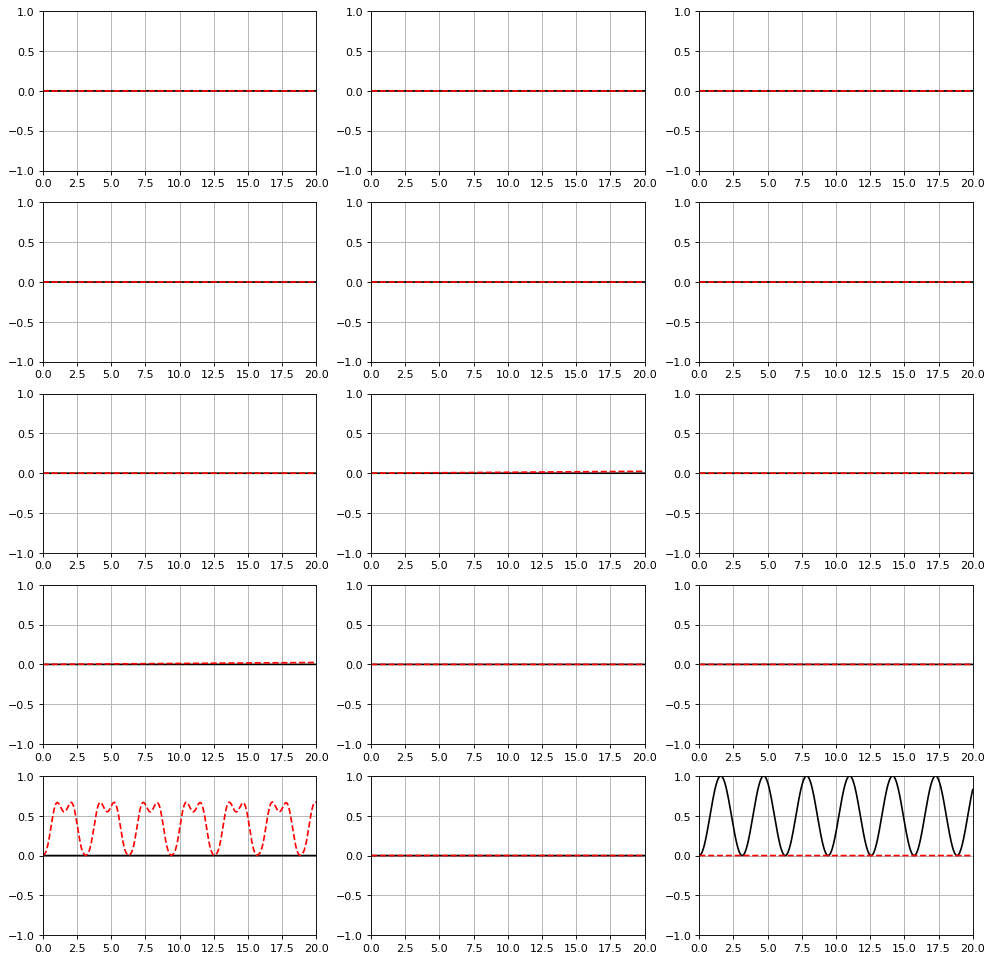

In [446]:
print_comparison_rates(L, model, 20)

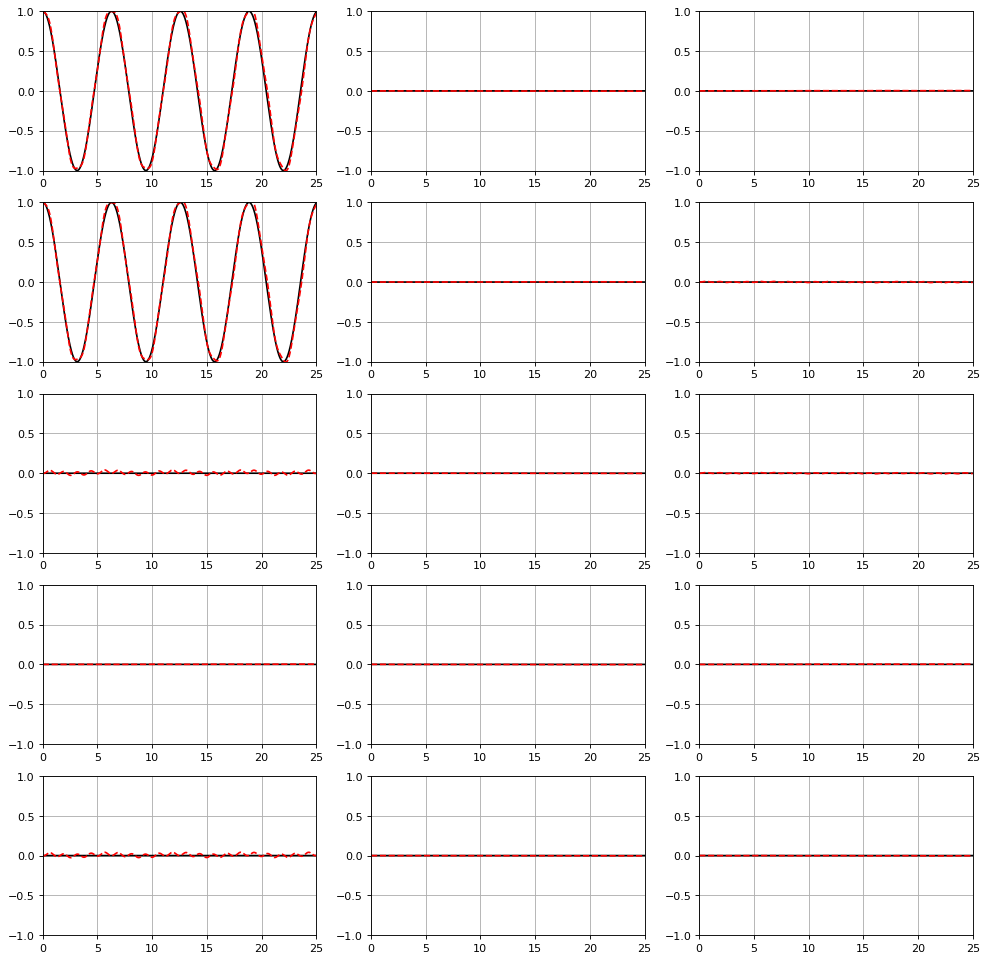

In [447]:
print_comparison_omega(L, model, 25)

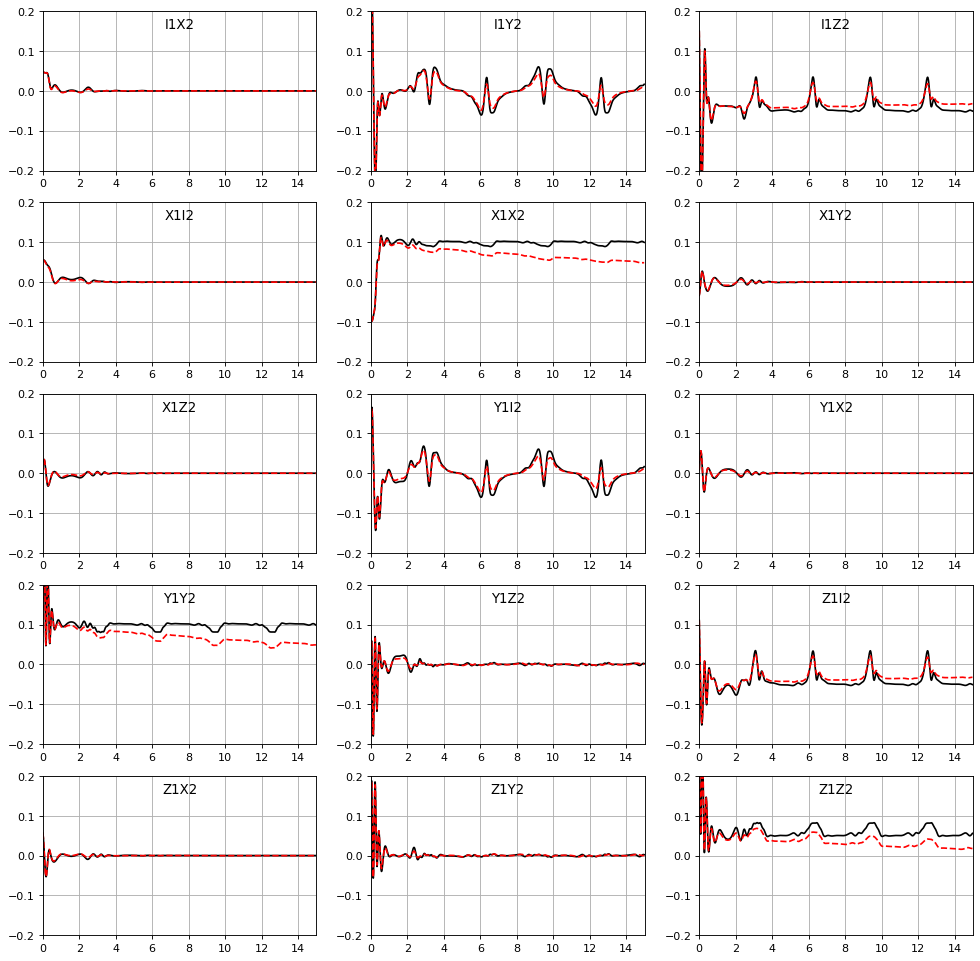

In [448]:
# import TEBD data
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)
with h5py.File('./data/data_TDL_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]
    
# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T_test'], beta=1)

print_comparison(data_tebd, ml_dyn, 15, dt=0.01, ylim=0.2)

# Lindblad 2 : Small frequencies
Do not learn well omega and gamma, BUT the dynamics is well reproduced!!

In [451]:
prms = {'model': 2,
        'omega_1': 0.1,
        'omega_2': 0.1,
        'T': 10,
        'T_test':20,
        'num_traj': 30}

L = L_1(prms['omega_1'],prms['omega_2'])

## Data Generation

In [275]:
### TRAINING
fname = './data/data_TDL_training.hdf5'
X = []
y = []

for i in range(prms['num_traj']):
    v_0 = initial_conditions()
    results = L.generate_trajectory(v_0=v_0, T=prms['T'])
    
    X.extend(results[:-1])
    y.extend(results[1:])

# save to file
file = h5py.File(fname, 'a')

# group name in hdf5 file
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)

# create the subgroup
subg = file.create_group(gname)

subg.create_dataset('X', data=X)
subg.create_dataset('y', data=y)

file.close()

In [276]:
### TESTING
fname = './data/data_TDL_test.hdf5'

v_0 = initial_conditions()
results = L.generate_trajectory(v_0=v_0, T=prms['T_test'])
    
X = results[:-1]
y = results[1:]

# save to file
file = h5py.File(fname, 'a')

# group name in hdf5 file
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)

# create the subgroup
subg = file.create_group(gname)

subg.create_dataset('X', data=X)
subg.create_dataset('y', data=y)

file.close()

## Model Training
In this case 3 frequencies @ 0.5, 1.5, 5

= Starting epoch  1 / 1500
=== Mean train loss: 18.064608554891
=== lr: 0.00995
= Starting epoch  2 / 1500
=== Mean train loss: 0.530823504671
=== lr: 0.00990
= Starting epoch  3 / 1500
=== Mean train loss: 0.380421472357
=== lr: 0.00985
= Starting epoch  4 / 1500
=== Mean train loss: 0.431146891193
=== lr: 0.00980
= Starting epoch  5 / 1500
=== Mean train loss: 0.464125277514
=== lr: 0.00975
= Starting epoch  6 / 1500
=== Mean train loss: 0.380565472106
=== lr: 0.00970
= Starting epoch  7 / 1500
=== Mean train loss: 0.526237660900
=== lr: 0.00966
= Starting epoch  8 / 1500
=== Mean train loss: 0.408791704381
=== lr: 0.00961
= Starting epoch  9 / 1500
=== Mean train loss: 0.443674881725
=== lr: 0.00956
= Starting epoch  10 / 1500
=== Mean train loss: 0.295947710092
=== lr: 0.00951
= Starting epoch  11 / 1500
=== Mean train loss: 0.434525838241
=== lr: 0.00946
= Starting epoch  12 / 1500
=== Mean train loss: 0.380318057664
=== lr: 0.00942
= Starting epoch  13 / 1500
=== Mean train loss:

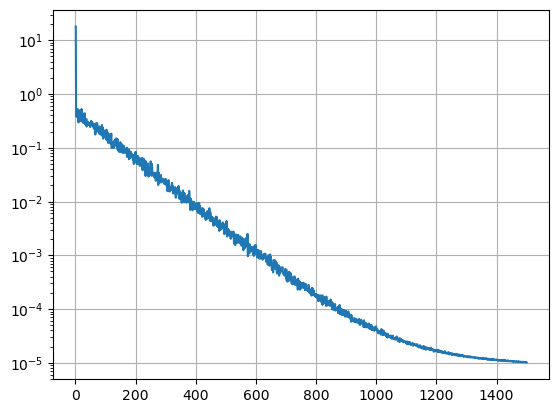

In [471]:
ml_params = {'model_dir': './data/trained_TDL/',  # folder where the metadata of the training are stored
             'validation_split': 0.9,
             'batch_size': 64,
             'time_dependent': True,
             # 'batches_per_epoch': 256,
             'n_epochs': 1500,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/data_TDL_training.hdf5', 
                                      prms['model'], prms['T'], prms['num_traj'], 
                                      ml_params['validation_split'],                                               
                                      ml_params['batch_size'])
# create the model
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01, betas=[0.8, 0.9])
scheduler = ExponentialLR(optimizer, 0.995)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            epochs_to_prune=[], lamda=1e-3)

# eval the model
#eval(model, criterion, eval_loader, ml_params['device'])

# save the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1,ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

In [472]:
print(model.MLP.gamma_net.frequencies)
print(model.MLP.omega_net.frequencies)

Parameter containing:
tensor([0.0144, 0.9271, 6.5279], requires_grad=True)
Parameter containing:
tensor([0.2684, 0.9333, 1.9268], requires_grad=True)


## Comparison

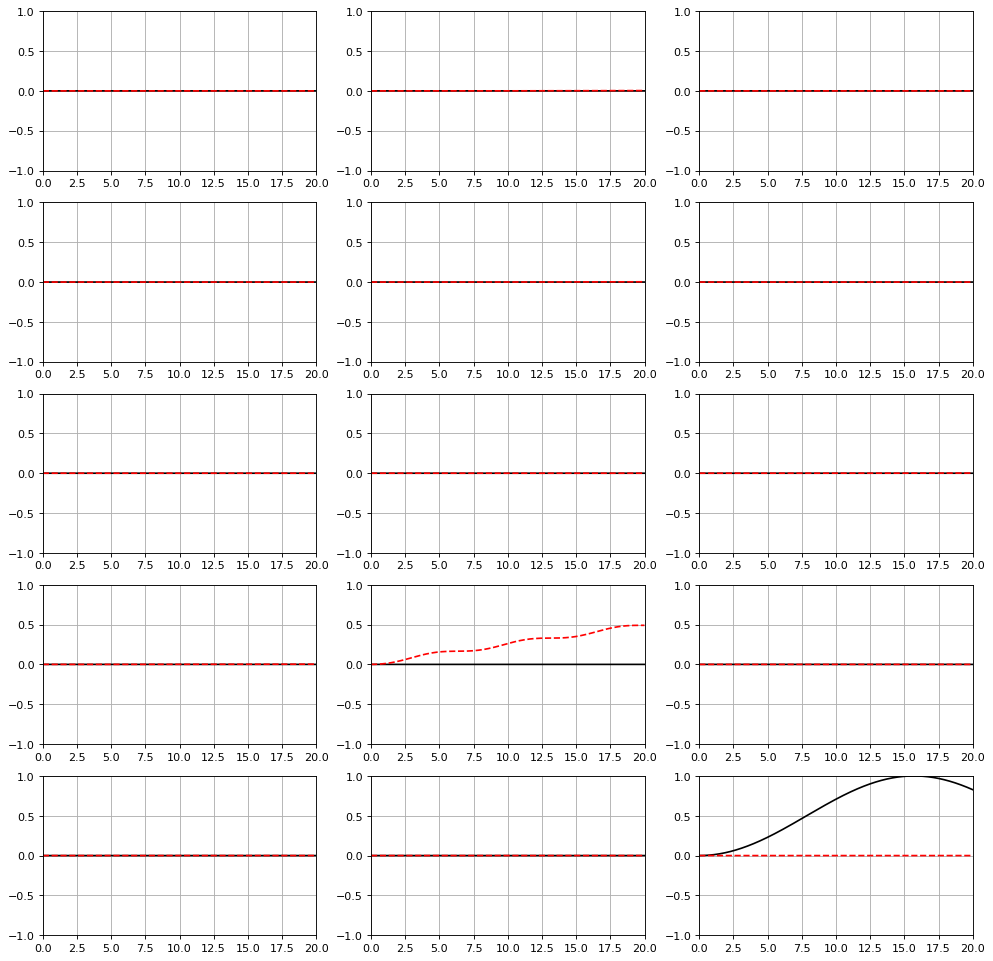

In [473]:
print_comparison_rates(L, model, 20)

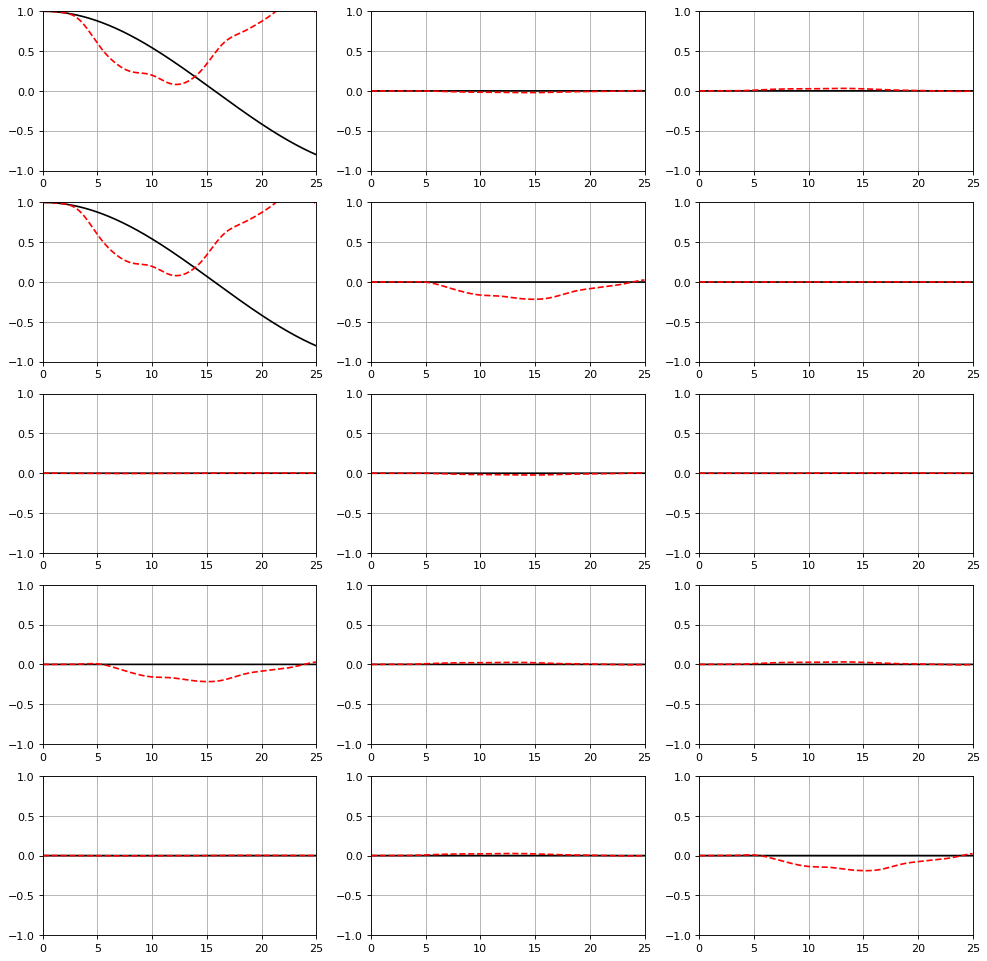

In [474]:
print_comparison_omega(L, model, 25)

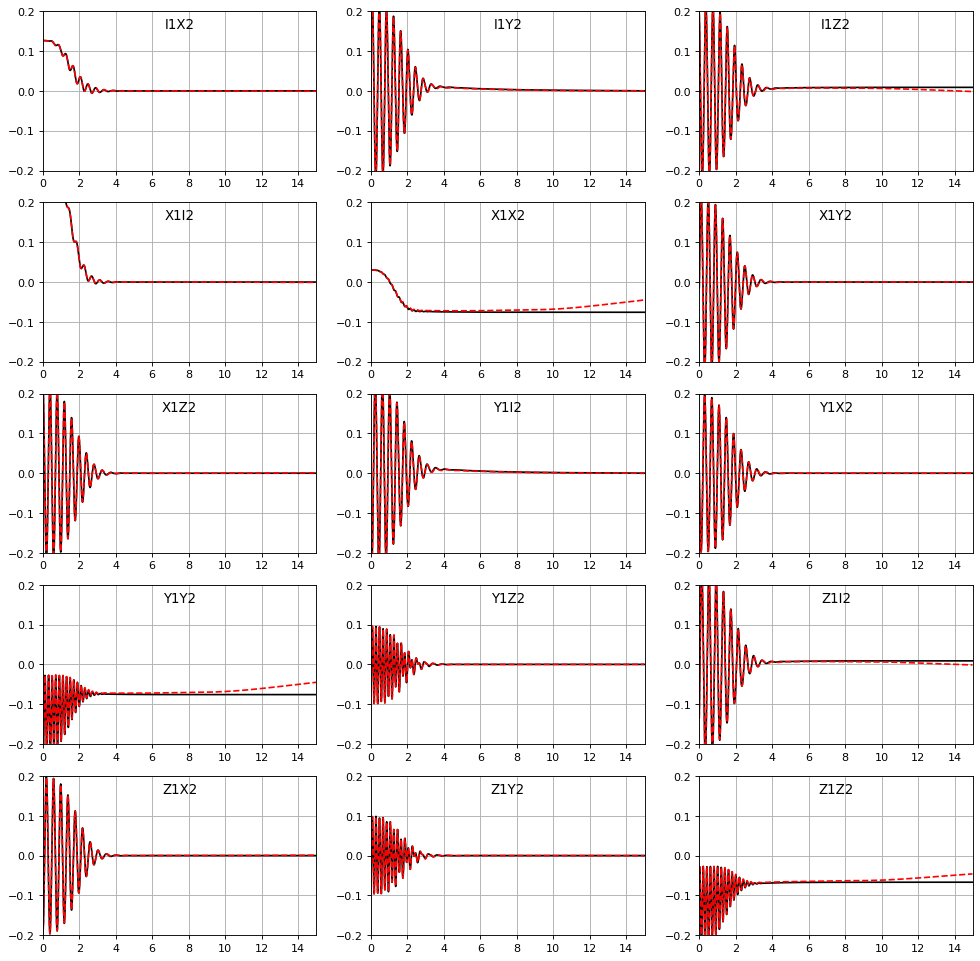

In [475]:
# import TEBD data
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)
with h5py.File('./data/data_TDL_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

model = MLLP(ml_params['mlp_params'], potential=0,
            time_dependent=ml_params['time_dependent']).to(ml_params['device'])
model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T_test'], beta=1)

print_comparison(data_tebd, ml_dyn, 15, dt=0.01, ylim=0.2)

# Lindblad 3

$$H = \frac{\cos(\omega_1 t)}{2} ( \sigma_1^x + \sigma_2^x  ) + \sin(\omega_2 t) (n_1 n_2) + \frac{\sin(\omega_3 t) \cos(\omega_4 t)}{2} (\sigma_1^y - \sigma_2^y)$$
$$J_1 = \frac{1}{2} \sin(\omega_5 t) ( \sigma_1^{-} \sigma_2^{-}  )$$
$$J_2 = \frac{1}{30} \sin^2(\omega_6 t) (\sigma_1^z - \sigma_2^z) $$
$$J_3 = \frac{1}{30} \cos(\omega_7 t) \sin(2 \omega_7 t) (\sigma_1^z \sigma_2^7)$$

In [37]:
class L_2(Lindbladian):
    def __init__(self, omega_1, omega_2, omega_3, omega_4, omega_5, omega_6, omega_7):
        super(L_2, self).__init__()
        self.o1 = omega_1
        self.o2 = omega_2
        self.o3 = omega_3
        self.o4 = omega_4
        self.o5 = omega_5
        self.o6 = omega_6
        self.o7 = omega_7
    
    def kossakowski(self, t):
        s_1 = torch.zeros((15), dtype=torch.cfloat)
        s_2 = torch.zeros((15), dtype=torch.cfloat)
        s_3 = torch.zeros((15), dtype=torch.cfloat)

        s_1[4] = 0.5
        s_1[5] = -0.5j
        s_1[8] = -0.5j
        s_1[9] = -0.5
        gamma_1 = 0.5*(np.sin(self.o5*t))**2
        
        s_2[0] = 2.0
        s_2[3] -= 2.0
        gamma_2 = 0*(1/30)*(np.sin(self.o6*t))**4
        
        s_3[14] = 4.0
        gamma_3 = (1/30)*((np.cos(self.o7*t))**2) * ((np.sin(2*self.o7*t))**2)

        koss = torch.einsum('i,j->ij', s_1, s_1.conj())*gamma_1
        koss += torch.einsum('i,j->ij', s_2, s_2.conj())*gamma_2
        koss += torch.einsum('i,j->ij', s_3, s_3.conj())*gamma_3
        return koss

    def omega(self, t):
        w = torch.zeros((15))
        w[0] = np.cos(self.o1*t)
        w[1] -= np.sin(self.o3*t)*np.cos(self.o4*t)
        w[2] = 0.5*np.sin(self.o2*t)
        w[3] = np.cos(self.o1*t)
        w[7] = np.sin(self.o3*t)*np.cos(self.o4*t)
        w[11] = 0.5*np.sin(self.o2*t)
        w[14] = 0.5*np.sin(self.o2*t)

        return w

In [38]:
prms = {'model': 3,
        'omega_1': 4,
        'omega_2': 1.1,
        'omega_3': 1,
        'omega_4': 0.6,
        'omega_5': 0.5,
        'omega_6': 1,
        'omega_7': 0.7,
        'T': 10,
        'T_test':20,
        'num_traj': 30}

L = L_2(prms['omega_1'],prms['omega_2'],prms['omega_3'],prms['omega_4'],prms['omega_5'],prms['omega_6'],prms['omega_7'])

## Data Generation

In [39]:
### TRAINING
fname = './data/data_TDL_training.hdf5'
X = []
y = []

for i in range(prms['num_traj']):
    v_0 = initial_conditions()
    results = L.generate_trajectory(v_0=v_0, T=prms['T'])
    
    X.extend(results[:-1])
    y.extend(results[1:])

# save to file
file = h5py.File(fname, 'a')

# group name in hdf5 file
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)

# create the subgroup
del file[gname]
subg = file.create_group(gname)

subg.create_dataset('X', data=X)
subg.create_dataset('y', data=y)

file.close()

In [40]:
### TESTING
fname = './data/data_TDL_test.hdf5'

v_0 = initial_conditions()
results = L.generate_trajectory(v_0=v_0, T=prms['T_test'])
    
X = results[:-1]
y = results[1:]

# save to file
file = h5py.File(fname, 'a')

# group name in hdf5 file
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)

# create the subgroup
del file[gname]
subg = file.create_group(gname)

subg.create_dataset('X', data=X)
subg.create_dataset('y', data=y)

file.close()

## Model training
In this case I give 4 frequencies to omega = [0.1, 0.5, 1, 5] and 3 to gamma = [0.1, 0.5, 1]

= Starting epoch  1 / 1500
=== Mean train loss: 1.681717740728
=== lr: 0.00995
= Starting epoch  2 / 1500
=== Mean train loss: 0.078106837426
=== lr: 0.00990
= Starting epoch  3 / 1500
=== Mean train loss: 0.048588403362
=== lr: 0.00985
= Starting epoch  4 / 1500
=== Mean train loss: 0.102253287476
=== lr: 0.00980
= Starting epoch  5 / 1500
=== Mean train loss: 0.629277342653
=== lr: 0.00975
= Starting epoch  6 / 1500
=== Mean train loss: 0.145612442787
=== lr: 0.00970
= Starting epoch  7 / 1500
=== Mean train loss: 0.498899608375
=== lr: 0.00966
= Starting epoch  8 / 1500
=== Mean train loss: 0.238303833740
=== lr: 0.00961
= Starting epoch  9 / 1500
=== Mean train loss: 0.437290230171
=== lr: 0.00956
= Starting epoch  10 / 1500
=== Mean train loss: 0.360514917193
=== lr: 0.00951
= Starting epoch  11 / 1500
=== Mean train loss: 0.646588028904
=== lr: 0.00946
= Starting epoch  12 / 1500
=== Mean train loss: 0.079494021595
=== lr: 0.00942
= Starting epoch  13 / 1500
=== Mean train loss: 

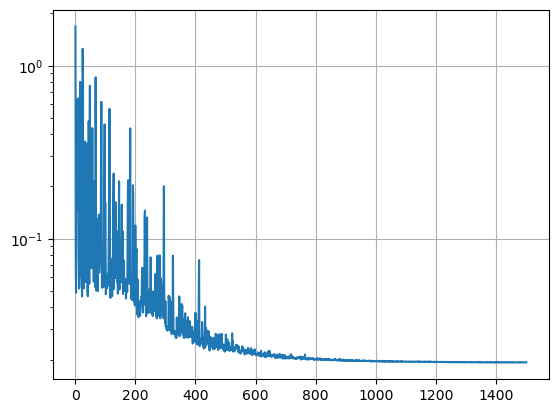

In [48]:
ml_params = {'model_dir': './data/trained_TDL/',  # folder where the metadata of the training are stored
             'validation_split': 0.9,
             'batch_size': 64,
             'time_dependent': True,
             # 'batches_per_epoch': 256,
             'n_epochs': 1500,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }

# load the data
train_loader, eval_loader = load_data('./data/data_TDL_training.hdf5', 
                                      prms['model'], prms['T'], prms['num_traj'], 
                                      ml_params['validation_split'],                                               
                                      ml_params['batch_size'])
# create the model
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01, betas=[0.8, 0.999])
scheduler = ExponentialLR(optimizer, 0.995)

# train the model
loss = train(model, criterion, optimizer, scheduler, train_loader,
            ml_params['n_epochs'], ml_params['device'],
            epochs_to_prune=[], lamda=1e-3)

# eval the model
#eval(model, criterion, eval_loader, ml_params['device'])

# save the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

torch.save(model.state_dict(), ml_params['model_dir'] + name)

plt.plot([i for i in range(1, ml_params['n_epochs']+1)], loss)
plt.yscale('log')
plt.grid()

## Comparison

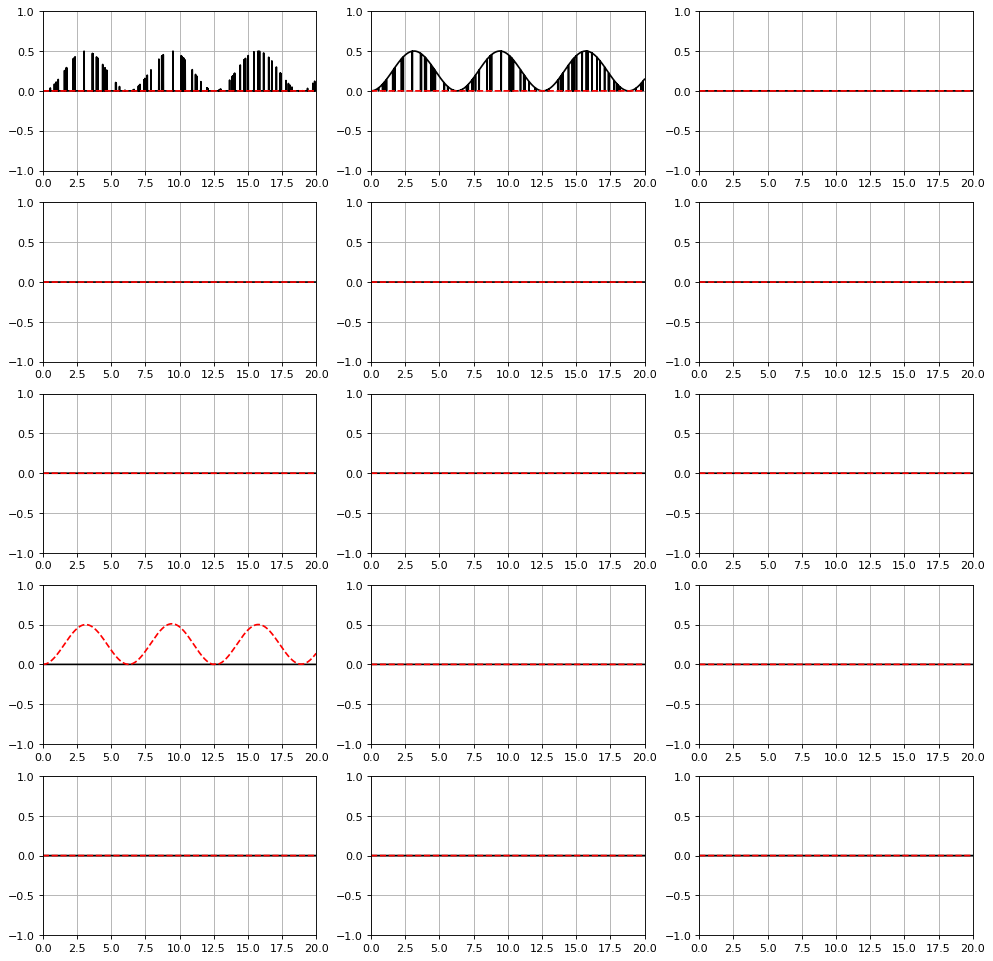

In [34]:
print_comparison_rates(L, model, 20)

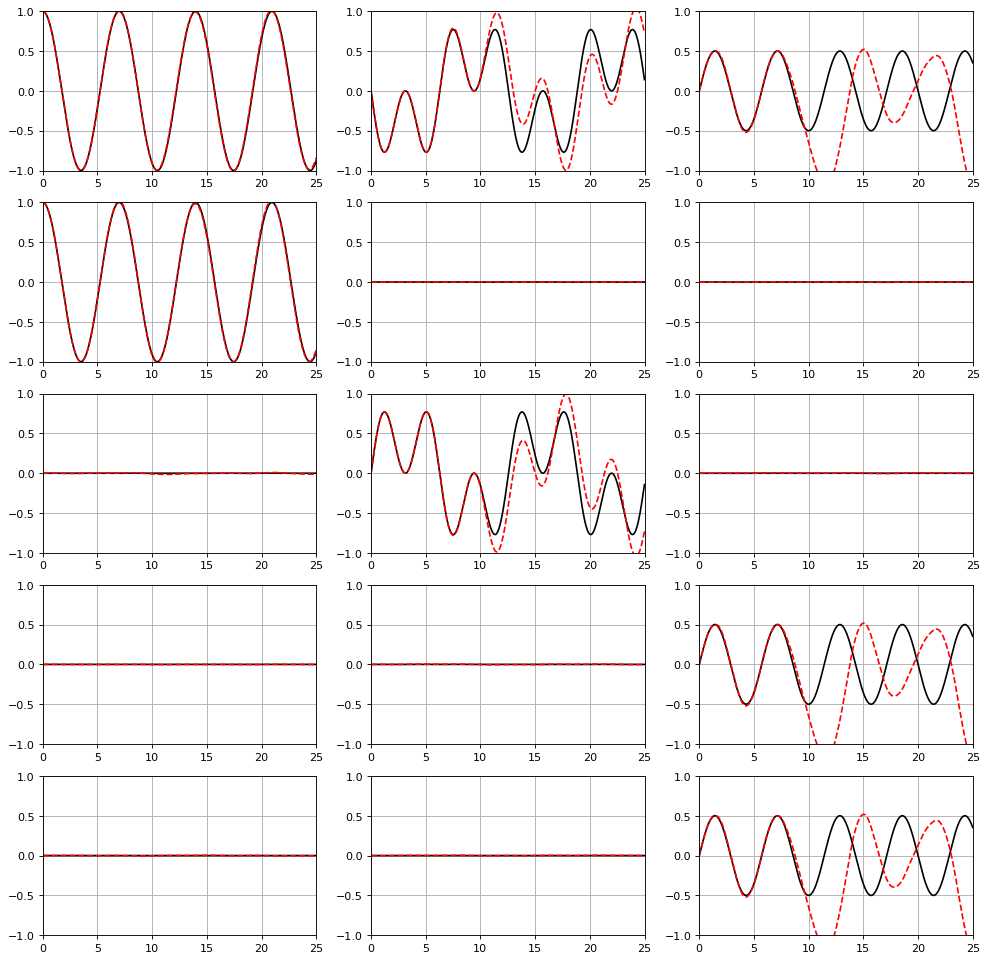

In [35]:
print_comparison_omega(L, model, 25)

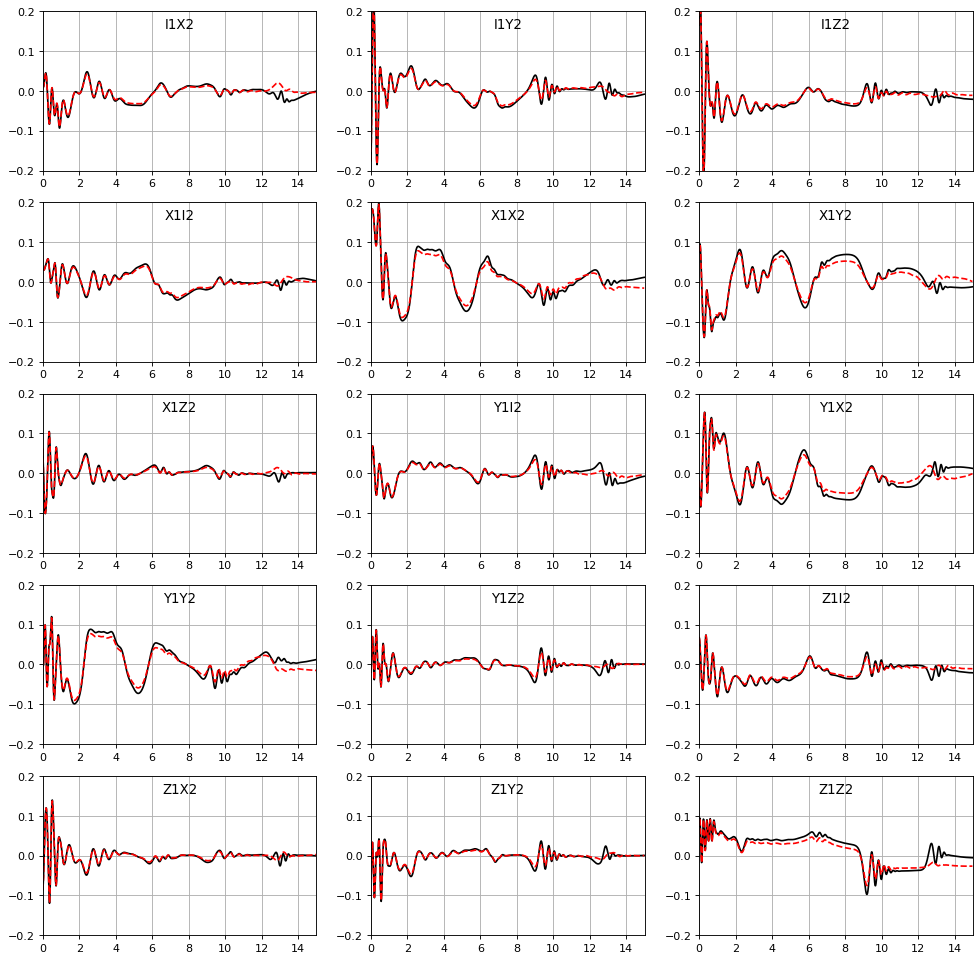

In [36]:
# import TEBD data
gname = 'cohVec_model' + str(prms['model']) + \
    '_T_' + str(prms['T']).zfill(2)
with h5py.File('./data/data_TDL_test.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_model' + str(prms['model']) + \
    '_T' + str(int(prms['T'])).zfill(2)

model = MLLP(ml_params['mlp_params'], potential=0,
            time_dependent=ml_params['time_dependent']).to(ml_params['device'])
model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T_test'], beta=1)

print_comparison(data_tebd, ml_dyn, 15, dt=0.01, ylim=0.2)